In [1]:
# Common imports
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os

# Plotting imports and settings
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (13,8)

In [2]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = "."

imgpath = os.path.join(PROJECT_ROOT_DIR, "images")
if not os.path.exists(imgpath):
    os.makedirs(imgpath)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# Volume Sold & Time
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# IowaSales_Copy_Filled
np.random.seed(42)
tf.random.set_seed(42)

## Load

In [4]:
isLocal = True

filename = "DATAFINAL.CSV"
google_drv_path = "C:/Users/tirth/Documents/LSTM/"
local_path = "C:/Users/tirth/Documents/LSTM/"
if not isLocal: 
  !pip install -U -q PyDrive
  from google.colab import drive
  drive.mount("/content/drive", force_remount=True)
  full_filepath = google_drv_path + filename
else:
  full_filepath = local_path + filename 

In [5]:

IowaSales_Cleaned = pd.read_csv(full_filepath, low_memory=False, parse_dates=True)
IowaSales_Cleaned.shape

CPU times: total: 0 ns
Wall time: 39.9 ms


(4092, 129)

In [6]:
IowaSales_Cleaned.head()

,Unnamed: 0,Date,Pack,Bottle Volume (ml),State Bottle Cost,Bottles Sold,Volume Sold (Liters),Longitude,Latitude,Month,...,County Number_91.0,County Number_92.0,County Number_93.0,County Number_94.0,County Number_95.0,County Number_96.0,County Number_97.0,County Number_98.0,County Number_99.0,Sale Days (Dollars)
0,14,2012-01-17,101632,8061000,73525.40,68091,66453.73,-775001.835562,349581.720541,8354,...,97,9,0,0,70,0,0,0,47,485706.536429
1,15,2012-01-18,86669,6937728,63562.57,64226,64060.86,-671871.801508,301044.385524,7178,...,17,139,0,389,0,0,160,0,75,484431.140000
2,16,2012-01-19,100719,7037878,67726.60,79211,71123.01,-721799.339014,326499.458280,7815,...,52,0,0,0,0,0,0,0,0,490269.047857
3,17,2012-01-20,0,0,0.00,0,0.00,0.000000,0.000000,0,...,0,0,0,0,0,0,0,0,0,490269.047857
4,18,2012-01-21,0,0,0.00,0,0.00,0.000000,0.000000,0,...,0,0,0,0,0,0,0,0,0,490269.047857


In [7]:
IowaSales_Cleaned["Date"].min()

'2012-01-17'

In [8]:
IowaSales_Cleaned["Date"].max()

'2023-03-31'

# LSTM #

In [9]:
# 80~20 - training set splitting.
TRAIN_SPLIT = int(len(IowaSales_Cleaned) * 0.8)
TRAIN_SPLIT

3273

In [10]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step):
    data = []
    labels = []

    start_index = (start_index + history_size) if start_index < history_size else start_index
    if end_index is None:
        end_index = len(dataset) - target_size
   
    for i in range(start_index, end_index):
        if ((i + step) >= end_index or i >= end_index): 
            break
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [11]:
def standardize(dataset, training_size):
    data_mean = dataset[:training_size].mean(axis=0)
    data_std = dataset[:training_size].std(axis=0)
    dataset_standardized = (dataset-data_mean)/data_std
    return dataset_standardized, data_mean, data_std

In [12]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [13]:
def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction, mean, std):
    plt.figure(figsize=(12, 6))
    
    num_in = create_time_steps(len(history))    
    num_out = len(true_future)

    hist_pos = history.shape[1] - 1;    
    invert_history = history * std + mean    
    
    plt.plot(num_in, np.array(invert_history[:, hist_pos]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'b-', label='True Future')

    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'r--', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [14]:
# LSTM neural network training related parameters 
past_history = 360
future_target = 60
n_neurons = [32, 16]
STEP = 6
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 200 
EPOCHS = 10

In [15]:
def LSTMmodel(X, target_size, n_neurons): 

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(n_neurons[0], return_sequences=True, input_shape=X.shape[-2:]))
    model.add(tf.keras.layers.LSTM(n_neurons[1], activation='relu'))
    model.add(tf.keras.layers.Dense(target_size))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
    
    return model

In [16]:
y_data = IowaSales_Cleaned["Sale Days (Dollars)"].values
X_data = IowaSales_Cleaned.drop(['Date'], axis=1).values
X_data_norm, X_data_mean, X_data_std = standardize(X_data, TRAIN_SPLIT)

In [18]:
X_train, y_train = multivariate_data(X_data_norm, y_data, 0,
                                     TRAIN_SPLIT, past_history,
                                     future_target, STEP)
X_val, y_val = multivariate_data(X_data_norm, y_data,
                                 TRAIN_SPLIT, None, past_history,
                                 future_target, STEP)

In [19]:
print ('Single window of past history : {}'.format(X_train[0].shape))
print ('\n Target to predict : {}'.format(y_train[0].shape))

Single window of past history : (60, 128)

 Target to predict : (60,)


In [20]:
train_data_slices = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data_slices = train_data_slices.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_slices = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_data_slices = val_data_slices.batch(BATCH_SIZE).repeat()

In [21]:
train_data_slices,val_data_slices,X_val.shape

(<_RepeatDataset element_spec=(TensorSpec(shape=(None, 60, 128), dtype=tf.float64, name=None), TensorSpec(shape=(None, 60), dtype=tf.float64, name=None))>,
 <_RepeatDataset element_spec=(TensorSpec(shape=(None, 60, 128), dtype=tf.float64, name=None), TensorSpec(shape=(None, 60), dtype=tf.float64, name=None))>,
 (753, 60, 128))

In [22]:
lstm = LSTMmodel(X_train, future_target, n_neurons)

In [23]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 32)            20608     
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 60)                1020      
                                                                 
Total params: 24,764
Trainable params: 24,764
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Quick look of the output structure
for x, y in val_data_slices.take(1):
    print('1', lstm.predict(x).shape)


8/8 [==============================] - 0s 7ms/step
1 (256, 60)


In [25]:
%%time
multi = lstm.fit(train_data_slices, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_data_slices,
                      validation_steps=50)

Epoch 1/10
200/200 [==============================] - 15s 65ms/step - loss: 767023.6875 - val_loss: 1068106.0000
Epoch 2/10
200/200 [==============================] - 13s 64ms/step - loss: 249366.1406 - val_loss: 176815.2500
Epoch 3/10
200/200 [==============================] - 12s 62ms/step - loss: 134854.6562 - val_loss: 162041.6562
Epoch 4/10
200/200 [==============================] - 13s 63ms/step - loss: 130844.1094 - val_loss: 158209.5938
Epoch 5/10
200/200 [==============================] - 13s 64ms/step - loss: 128524.3672 - val_loss: 156119.1094
Epoch 6/10
200/200 [==============================] - 11s 57ms/step - loss: 126612.3672 - val_loss: 150860.3750
Epoch 7/10
200/200 [==============================] - 11s 57ms/step - loss: 125488.3516 - val_loss: 149246.0156
Epoch 8/10
200/200 [==============================] - 12s 58ms/step - loss: 124351.2109 - val_loss: 147333.3750
Epoch 9/10
200/200 [==============================] - 12s 58ms/step - loss: 123122.8750 - val_loss: 143

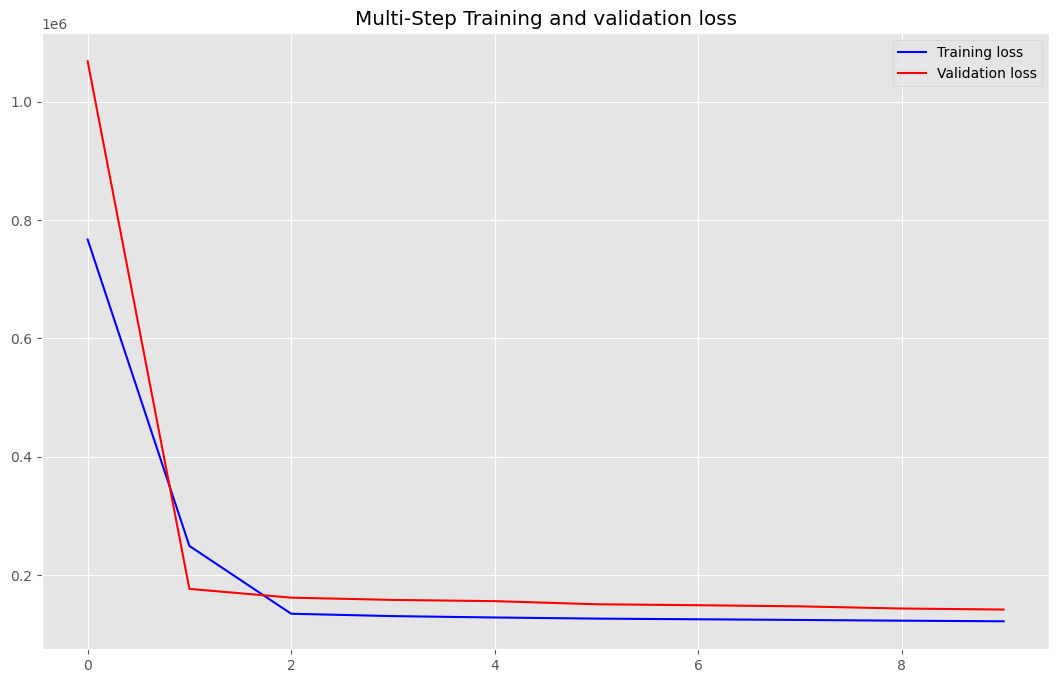

In [26]:
plot_train_history(multi, 'Multi-Step Training and validation loss')

In [27]:
X_data.shape

(4092, 128)

8/8 [==============================] - 0s 6ms/step


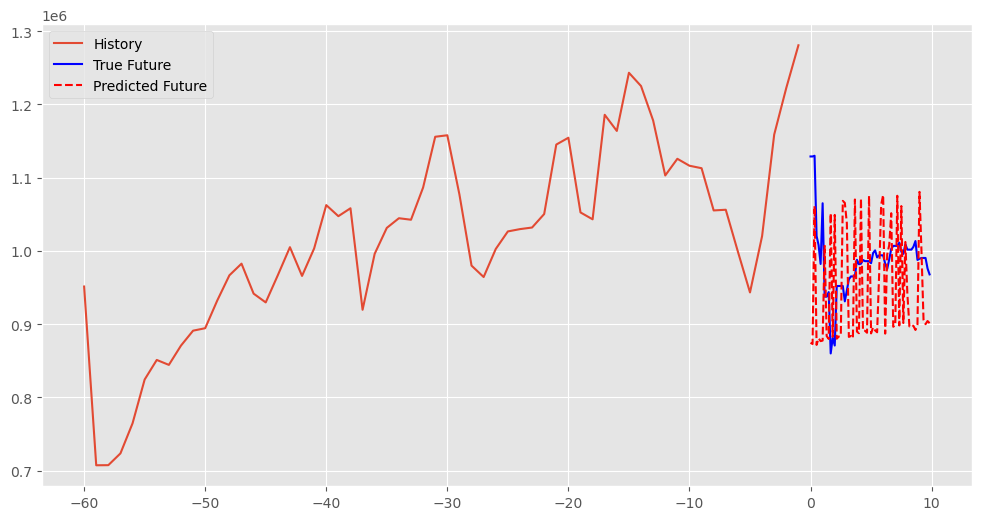

8/8 [==============================] - 0s 6ms/step


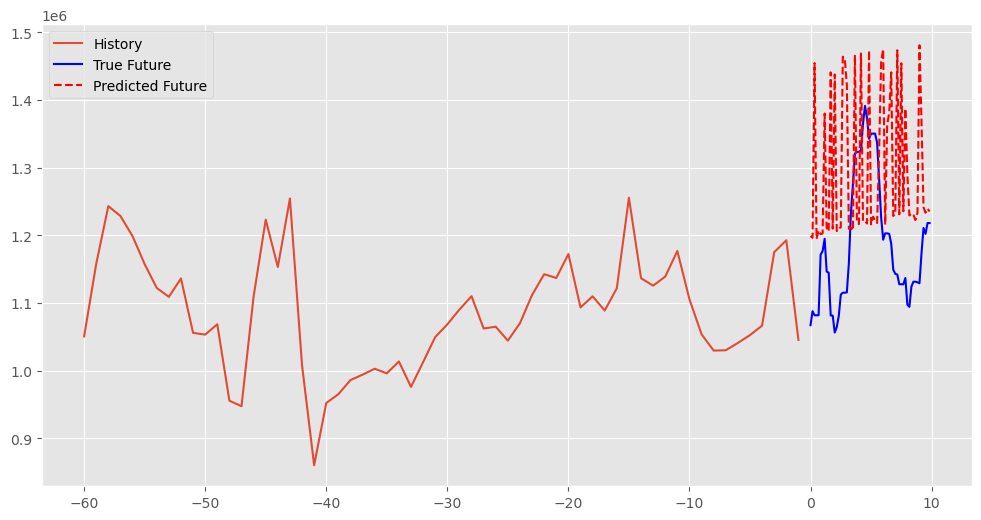

8/8 [==============================] - 0s 5ms/step


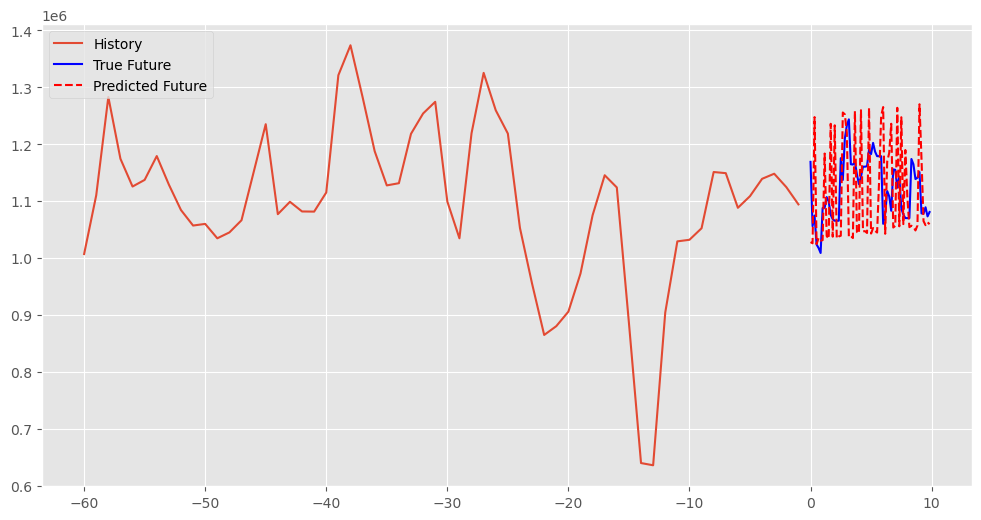

8/8 [==============================] - 0s 6ms/step


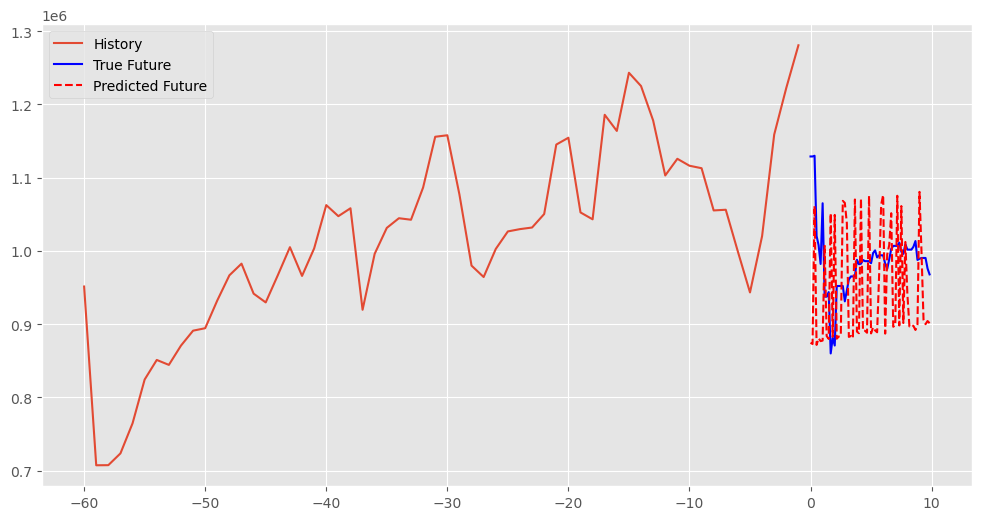

8/8 [==============================] - 0s 6ms/step


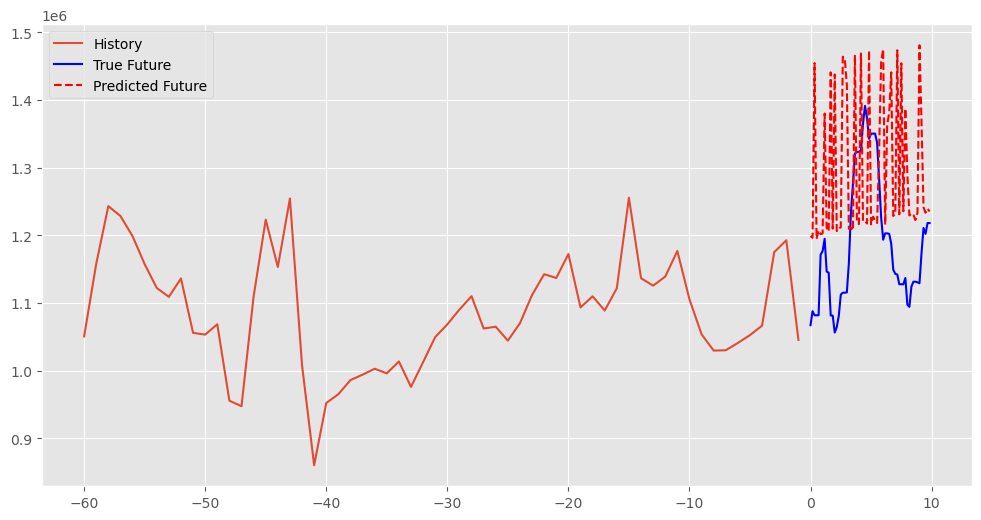

8/8 [==============================] - 0s 5ms/step


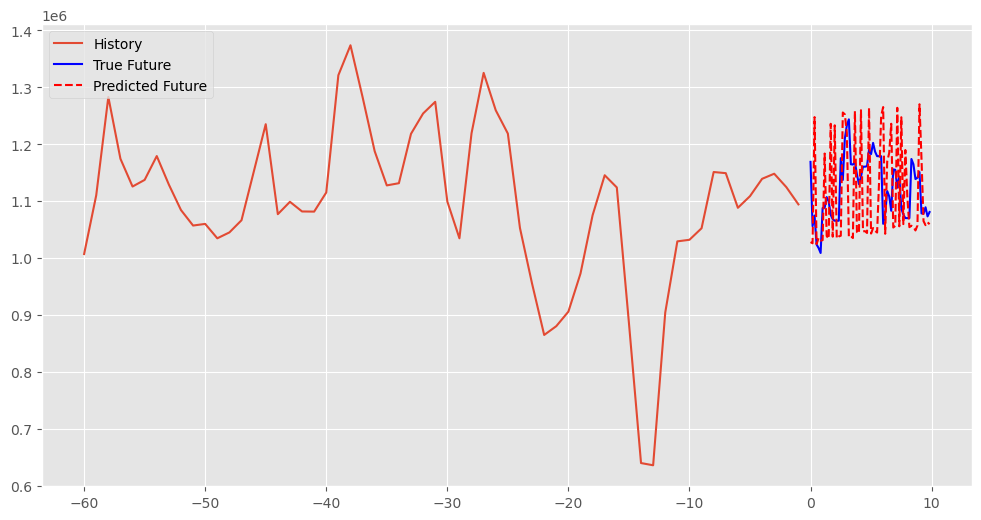

8/8 [==============================] - 0s 6ms/step


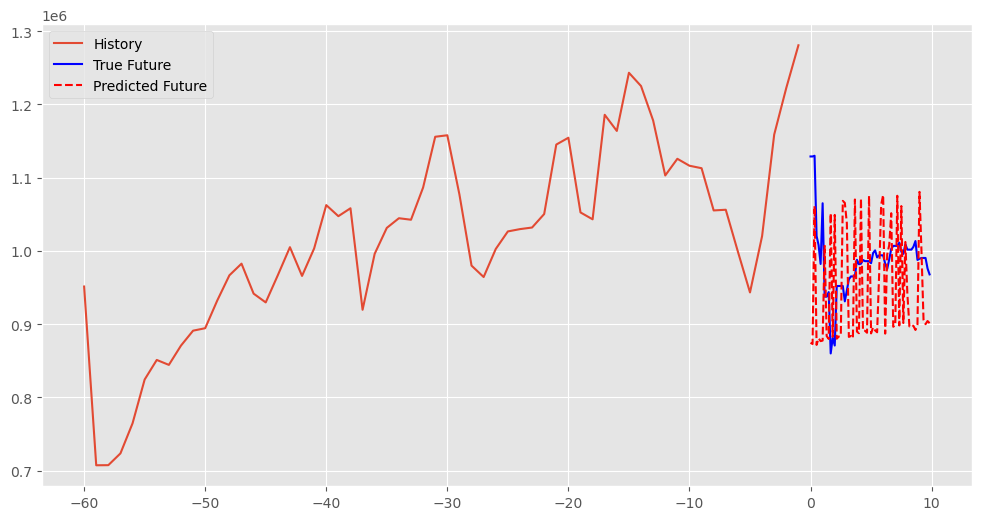

8/8 [==============================] - 0s 6ms/step


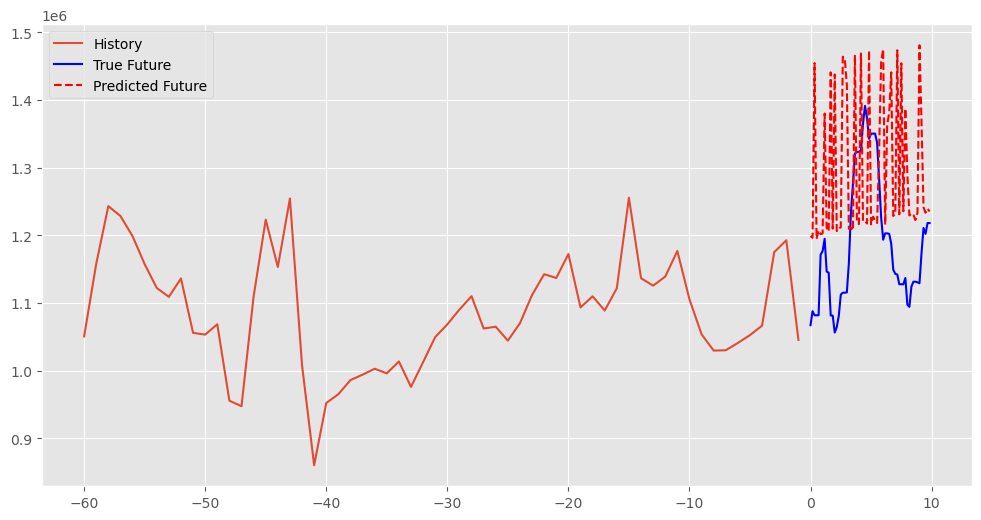

8/8 [==============================] - 0s 5ms/step


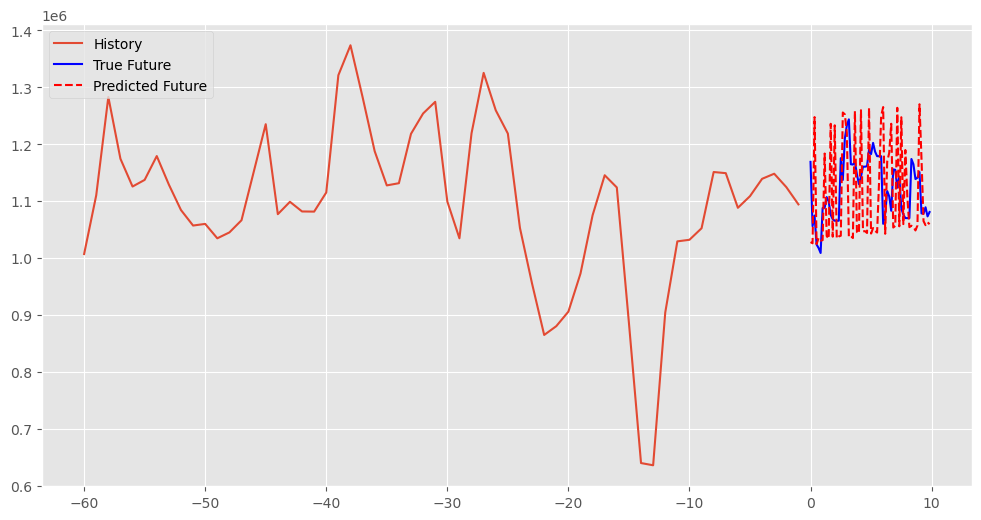

8/8 [==============================] - 0s 6ms/step


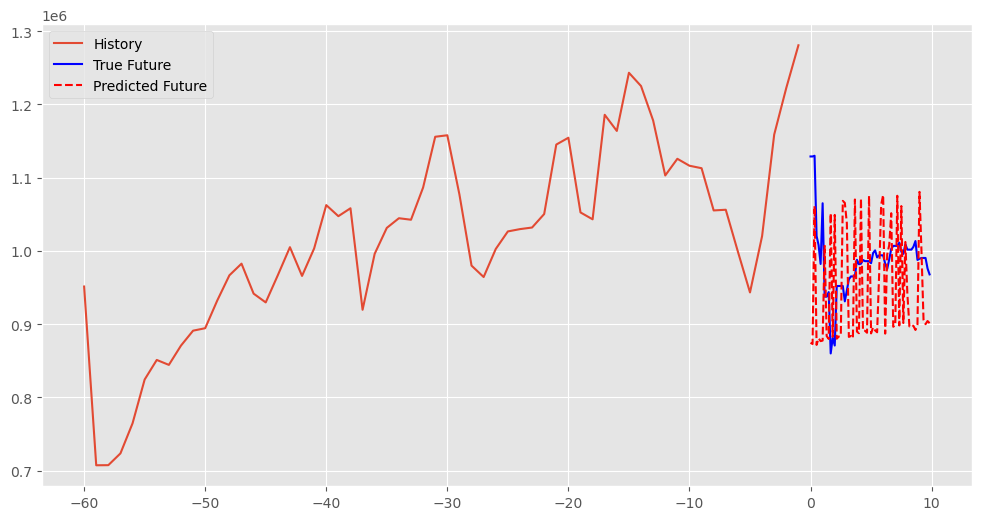

8/8 [==============================] - 0s 6ms/step


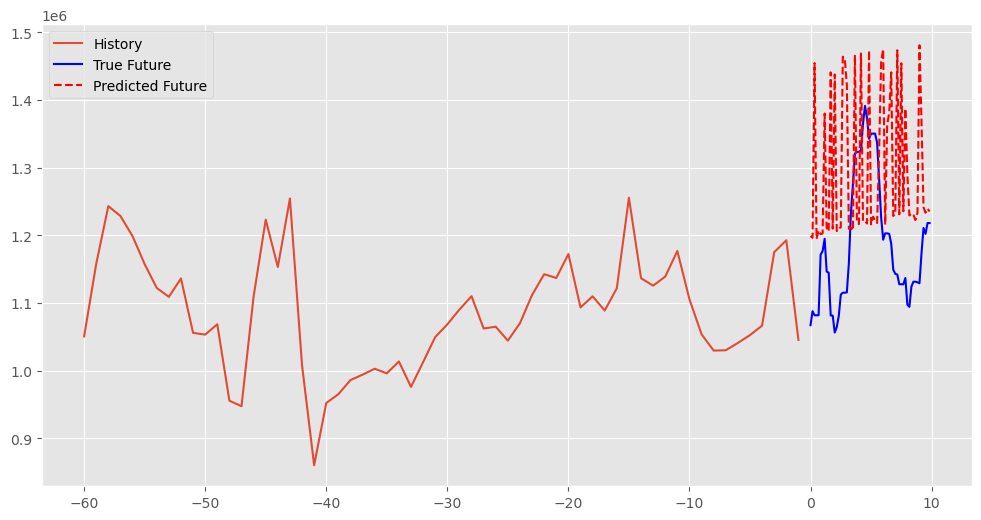

8/8 [==============================] - 0s 5ms/step


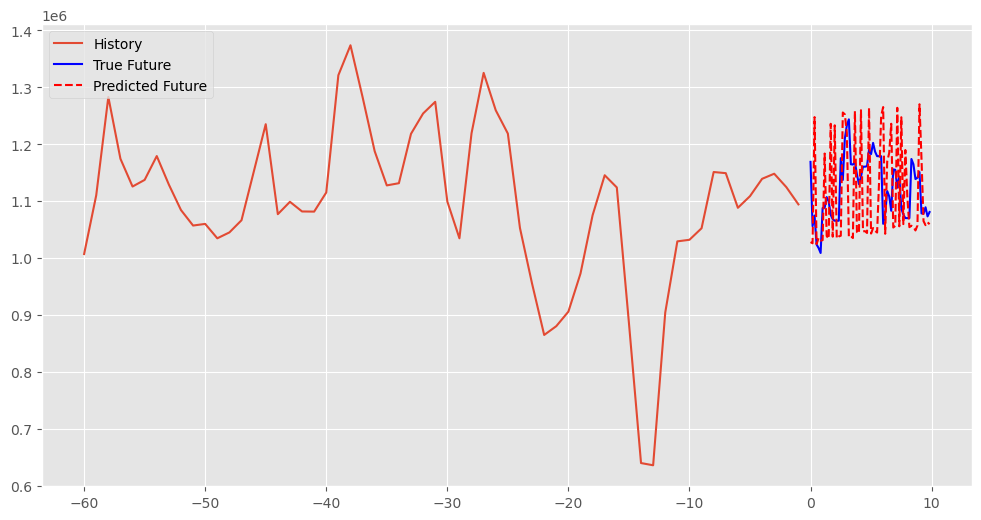

8/8 [==============================] - 0s 5ms/step


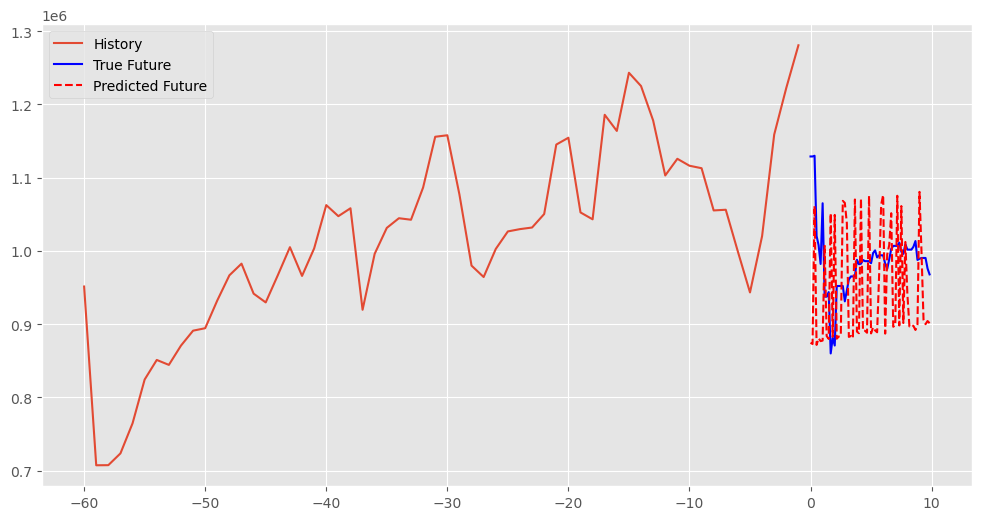

8/8 [==============================] - 0s 6ms/step


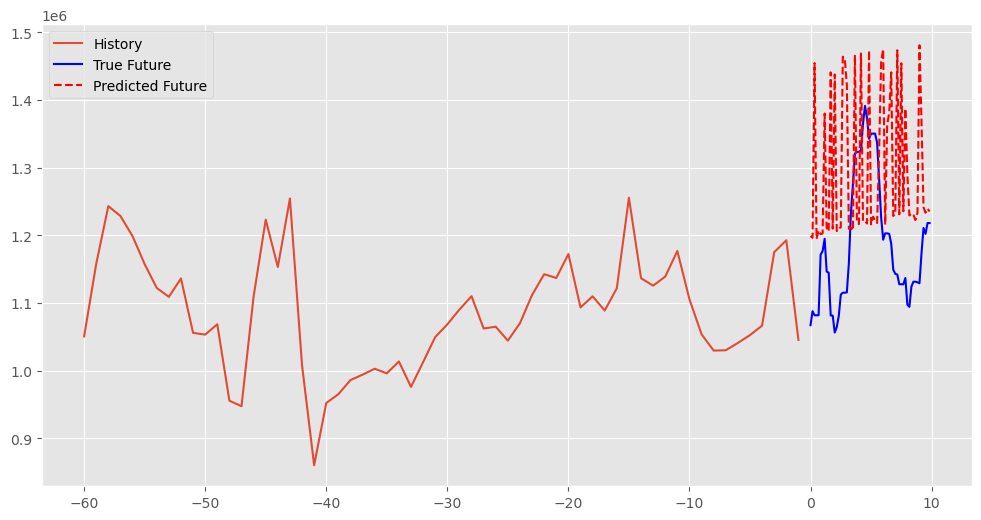

8/8 [==============================] - 0s 6ms/step


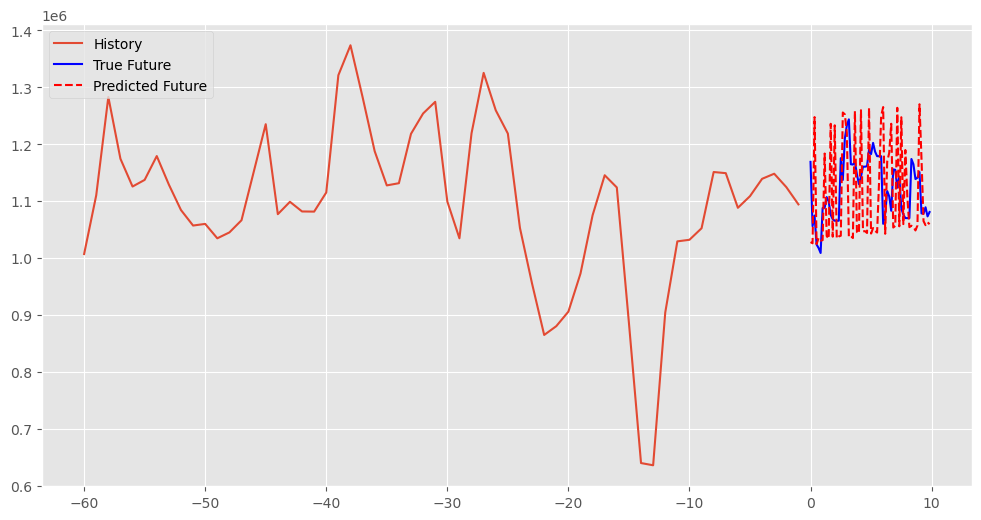

8/8 [==============================] - 0s 6ms/step


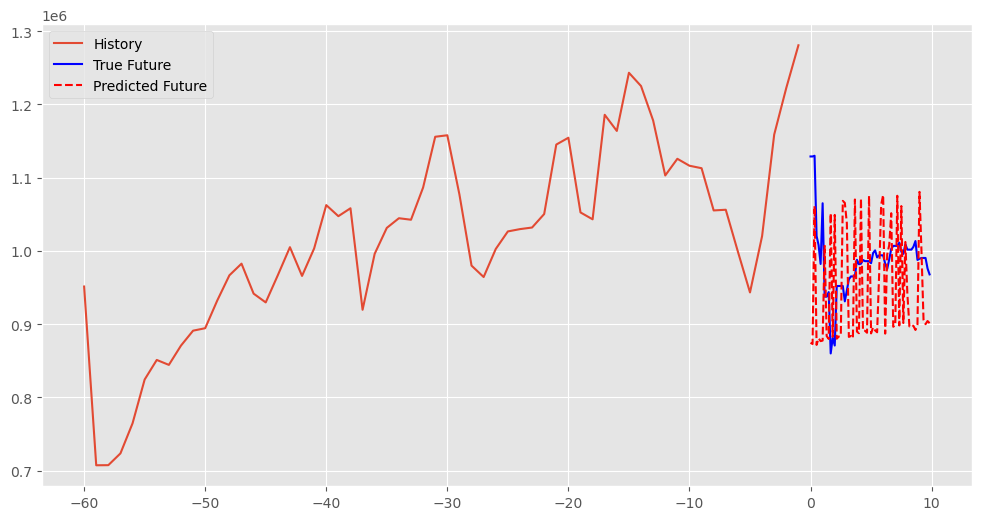

8/8 [==============================] - 0s 6ms/step


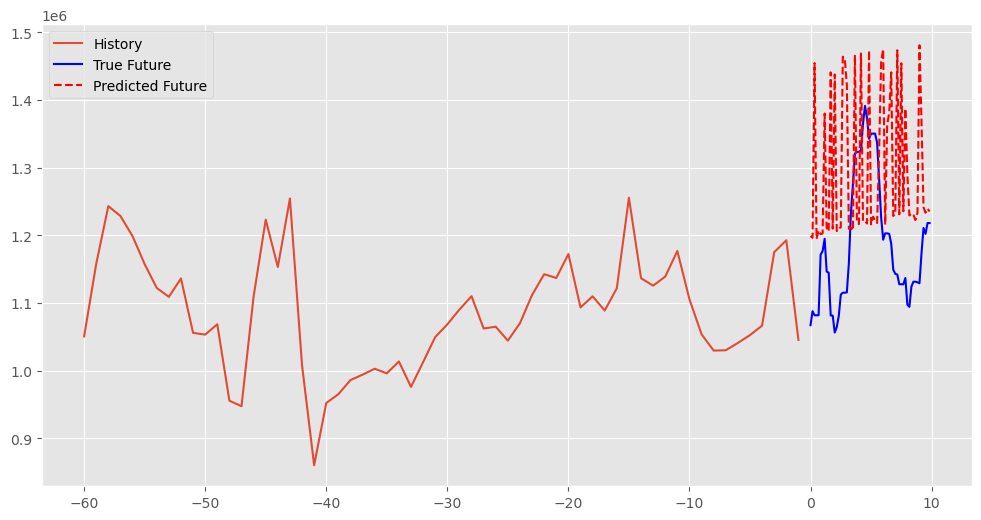

8/8 [==============================] - 0s 6ms/step


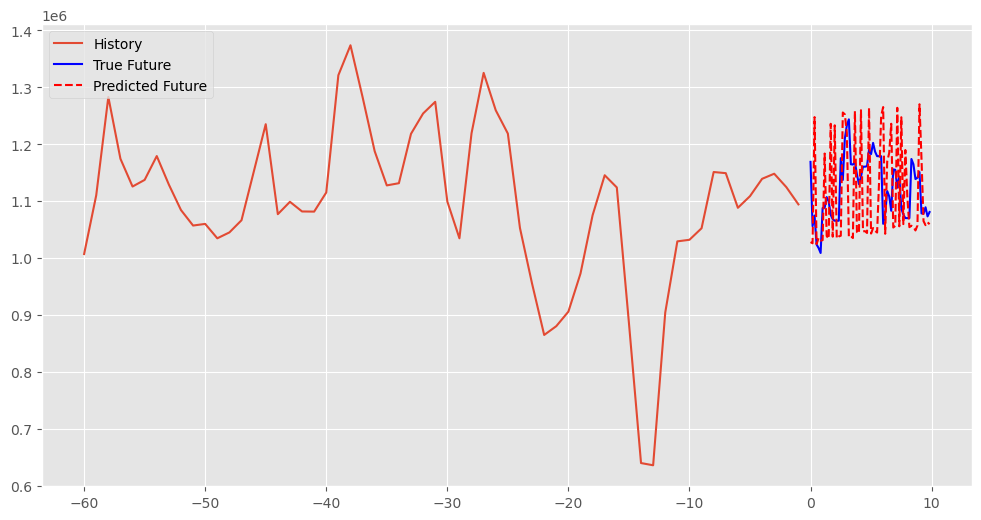

8/8 [==============================] - 0s 6ms/step


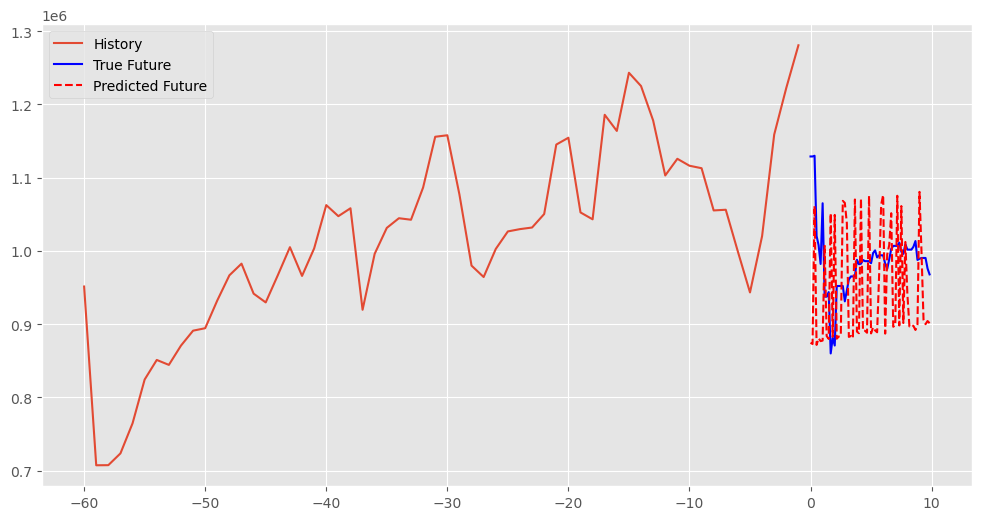

8/8 [==============================] - 0s 6ms/step


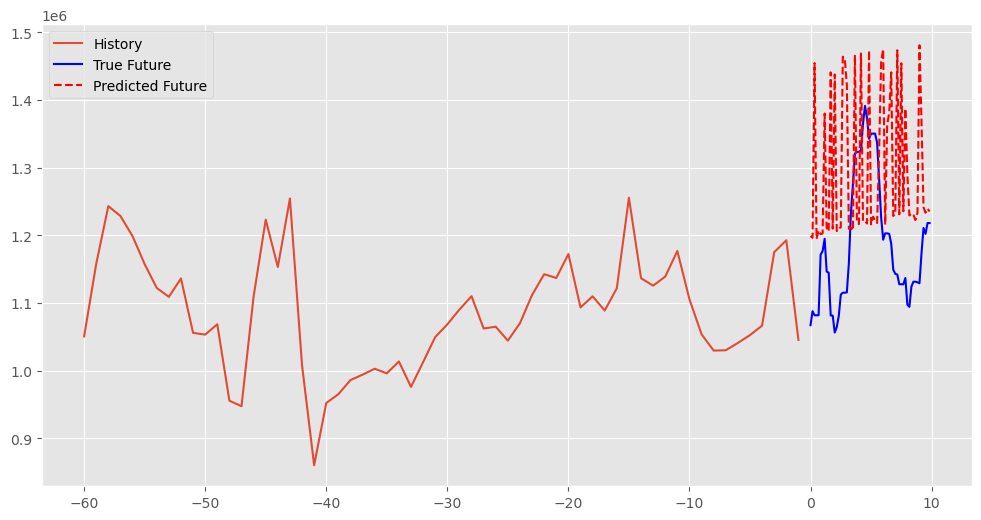

In [28]:
# print(X_val[:1])

for x, y in val_data_slices.take(20):
    multi_step_plot(x[0], y[0], lstm.predict(x)[0], X_data_mean, X_data_std)

8/8 [==============================] - 0s 6ms/step


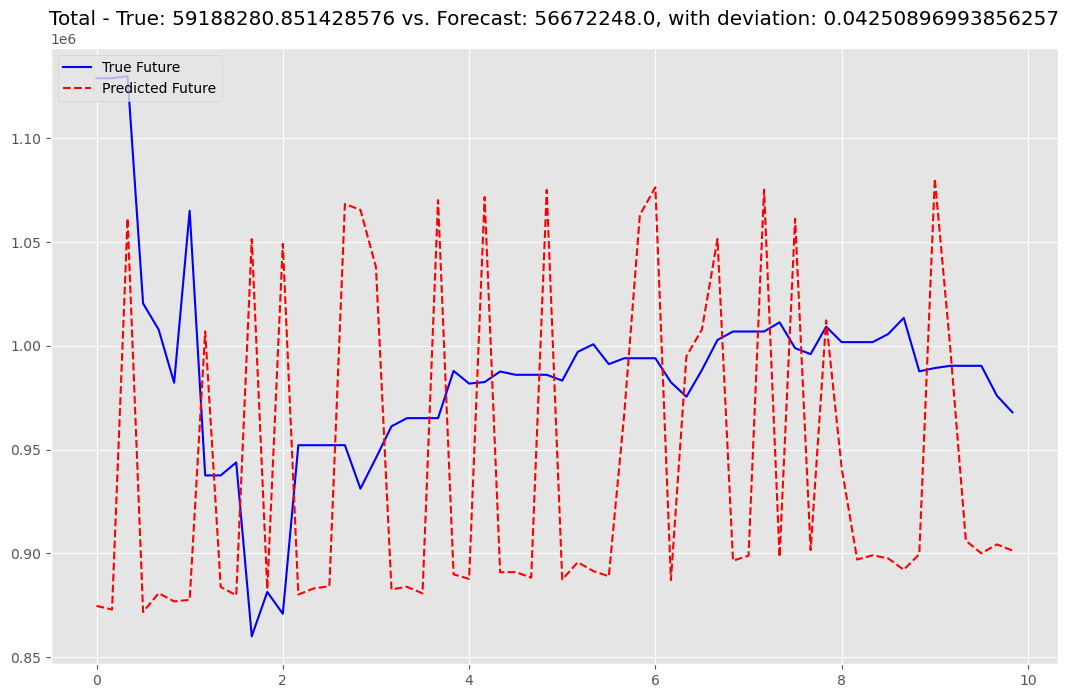

8/8 [==============================] - 0s 6ms/step


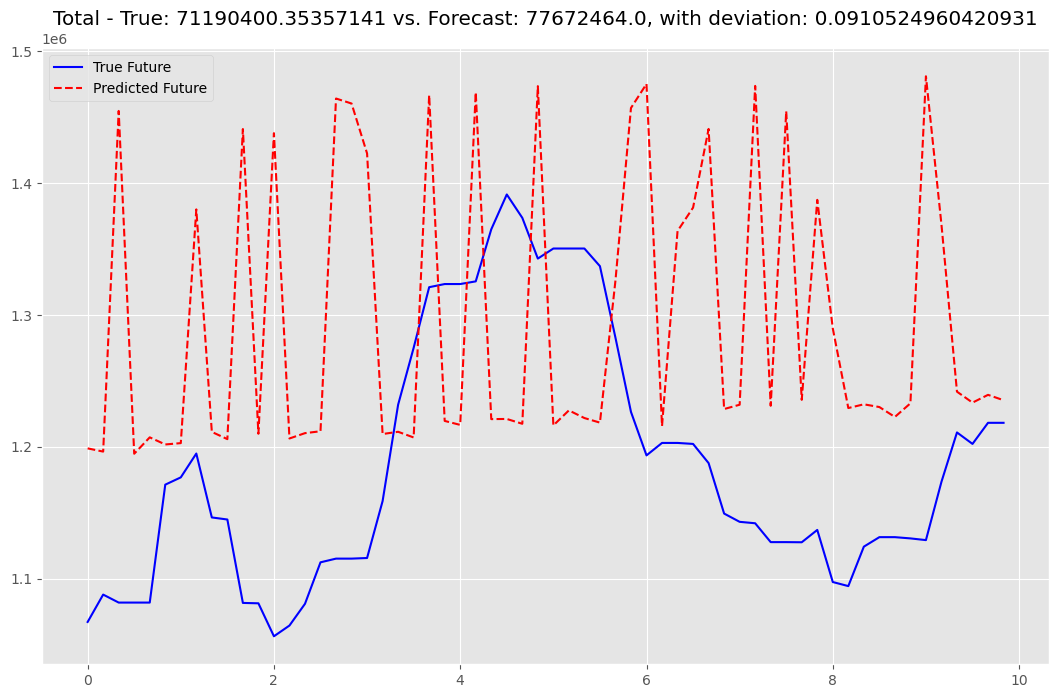

8/8 [==============================] - 0s 6ms/step


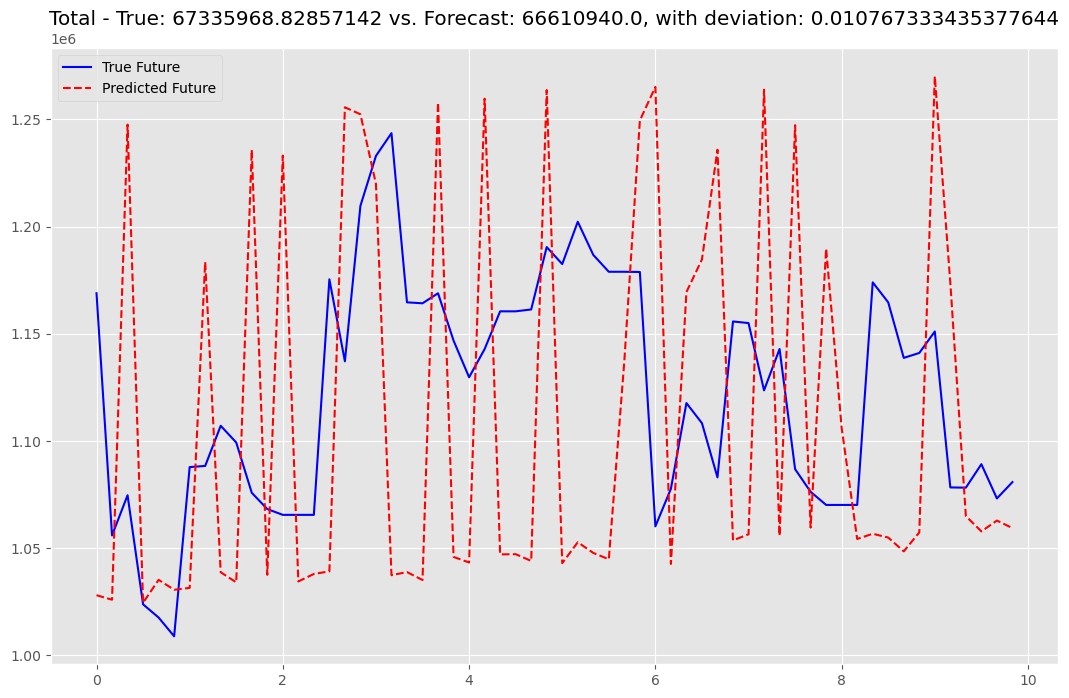

8/8 [==============================] - 0s 6ms/step


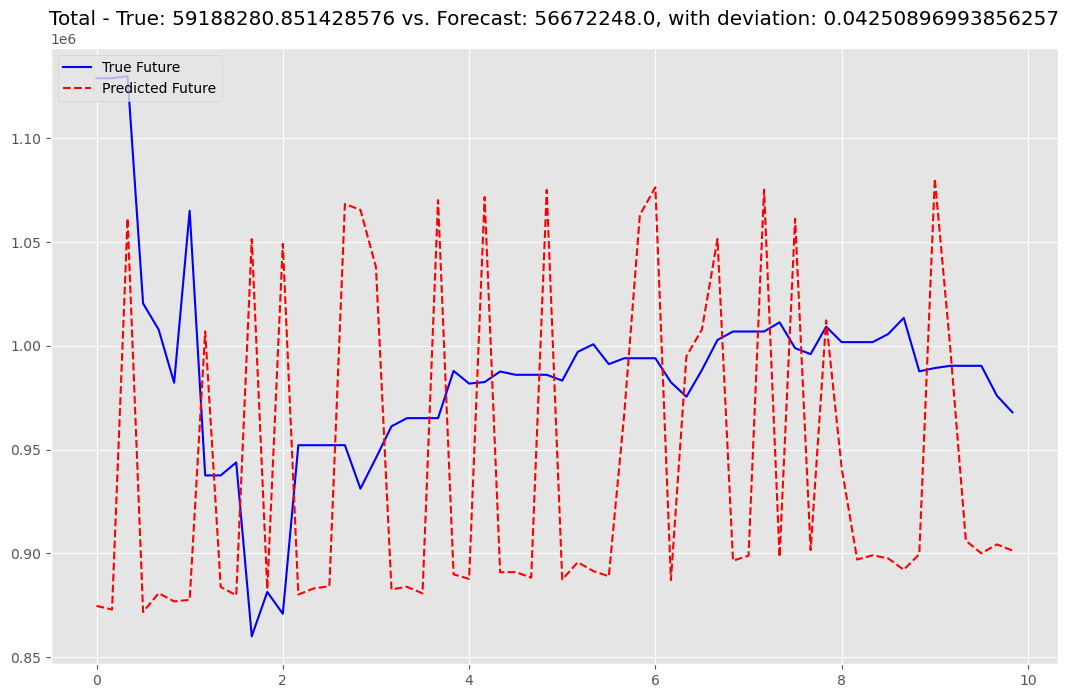

8/8 [==============================] - 0s 6ms/step


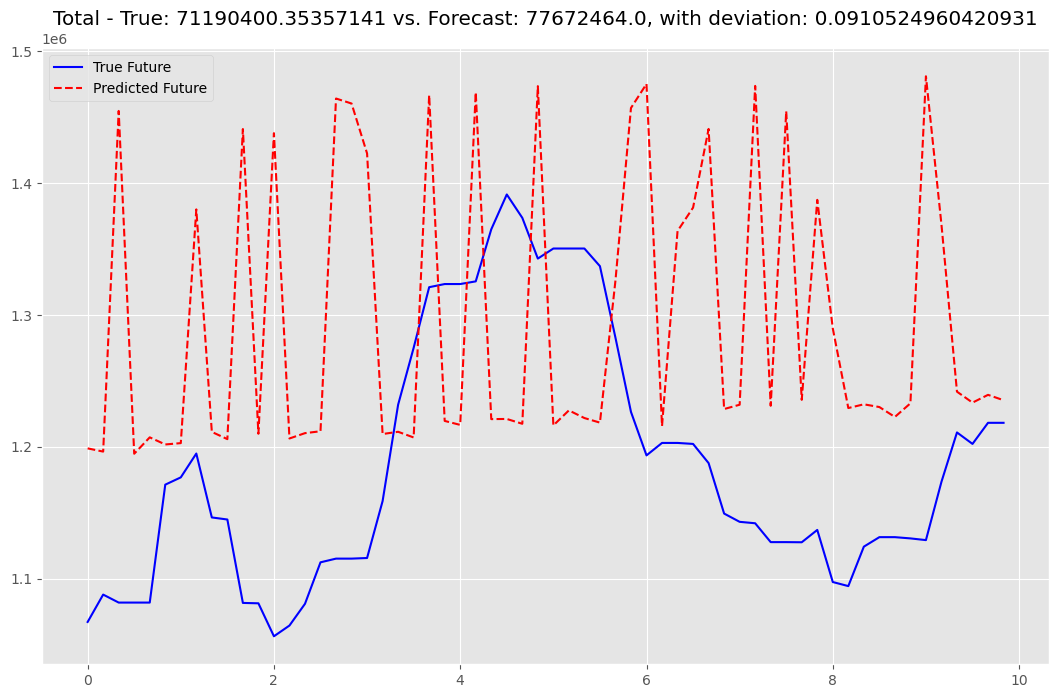

8/8 [==============================] - 0s 6ms/step
Overall accuracy mean: 0.9524504631813338 (i.e. inaccuracy mean: 0.047549536818666256), Deviation: 0.03136549553038408 for sampled 10 forecasting.


In [29]:
deviations = list()
plot_limit = 5
for x, y in val_data_slices.take(10):
    true_future = y[0]
    predict_future = lstm.predict(x)[0]
    mean, std = X_data_mean, X_data_std    
    future_num = np.arange(len(true_future))/STEP   
    
    t_sum = np.sum(true_future)
    p_sum = np.sum(predict_future)
    dev = np.absolute((p_sum - t_sum)/t_sum)
    
    if plot_limit > 0: 
        plt.plot(future_num, np.array(true_future), 'b-', label='True Future')
        plt.plot(future_num, np.array(predict_future), 'r--', label='Predicted Future')
        plt.legend(loc='upper left')
        plot_limit = plot_limit - 1
        plt.title(F"Total - True: {t_sum} vs. Forecast: {p_sum}, with deviation: {dev}")
        plt.show()
    
    deviations.append(dev)  
    
dev_mean = np.mean(deviations)
dev_std = np.std(deviations)
print(F"Overall accuracy mean: { 1 - dev_mean} (i.e. inaccuracy mean: {dev_mean}), Deviation: {dev_std} for sampled {len(deviations)} forecasting.")
